## 工具包安装方法：
- 一定参考其GITHUB：https://github.com/pyg-team/pytorch_geometric
(千万不要pip直接安装，肯定不行的)


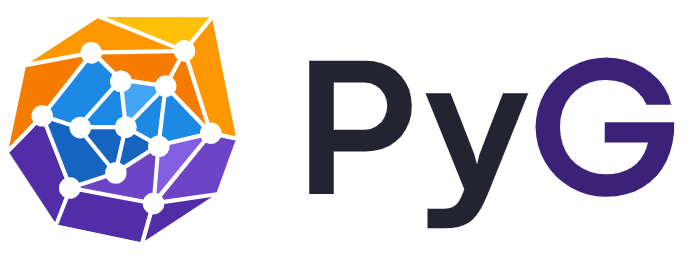

In [1]:
%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt


def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

### Graph Neural Networks
- 致力于解决不规则数据结构（图像和文本相对格式都固定，但是社交网络与化学分子等格式肯定不是固定的）
- GNN模型迭代更新主要基于图中每个节点及其邻居的信息，基本表示如下：

$$
\mathbf{x}_v^{(\ell + 1)} = f^{(\ell + 1)}_{\theta} \left( \mathbf{x}_v^{(\ell)}, \left\{ \mathbf{x}_w^{(\ell)} : w \in \mathcal{N}(v) \right\} \right)
$$

节点的特征： $\mathbf{x}_v^{(\ell)}$ ， $v \in \mathcal{V}$ 在图中 $\mathcal{G} = (\mathcal{V}, \mathcal{E})$ 根据其邻居信息进行更新 $\mathcal{N}(v)$:

### 数据集：Zachary's karate club network.
该图描述了一个空手道俱乐部会员的社交关系，以34名会员作为节点，如果两位会员在俱乐部之外仍保持社交关系，则在节点间增加一条边。
每个节点具有一个34维的特征向量，一共有78条边。
在收集数据的过程中，管理人员 John A 和 教练 Mr. Hi（化名）之间产生了冲突，会员们选择了站队，一半会员跟随 Mr. Hi 成立了新俱乐部，剩下一半会员找了新教练或退出了俱乐部。
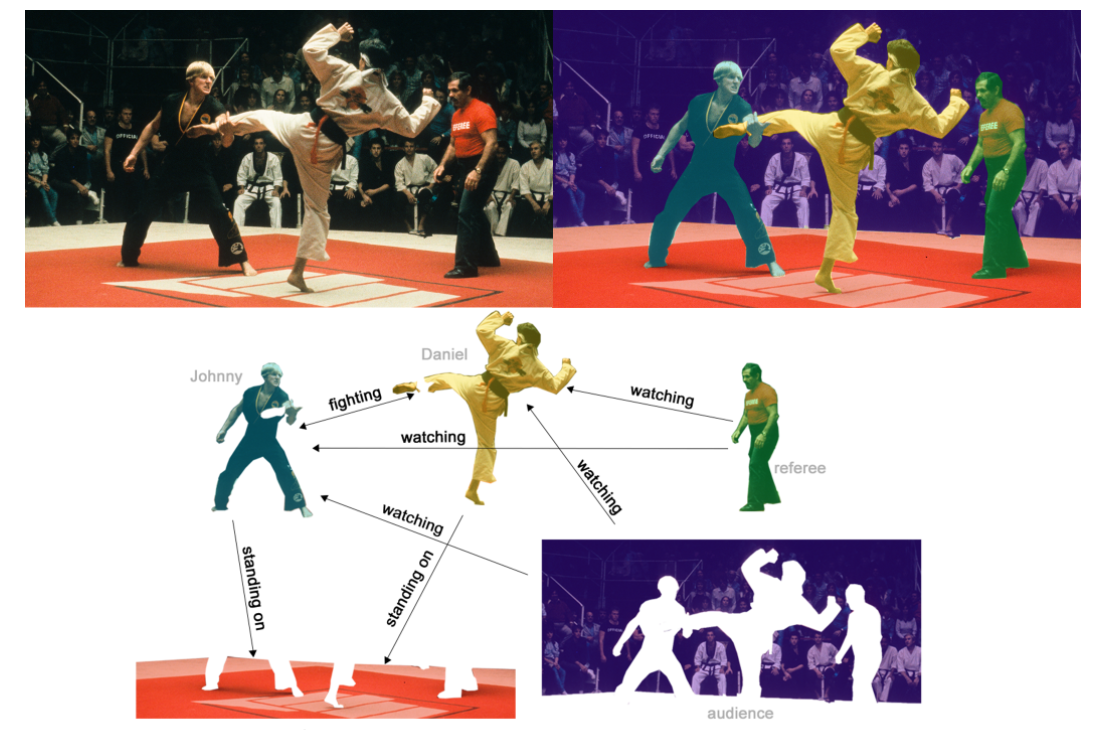

### PyTorch Geometric
- 这个就是咱们的核心了，说白了就是这里实现了各种图神经网络中的方法
- 咱们直接调用就可以了：[PyTorch Geometric (PyG) library](https://github.com/rusty1s/pytorch_geometric)

#### 数据集介绍
- 可以直接参考其API：https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.KarateClub

In [2]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [3]:
data = dataset[0]  # Get the first graph object.

print(data)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


- 图的表示用[`Data`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data)格式（说明可以点击）

### edge_index
- edge_index：表示图的连接关系（start,end两个序列）
- node features：每个点的特征
- node labels：每个点的标签
- train_mask：有的节点木有标签（用来表示哪些节点要计算损失）

In [4]:
edge_index = data.edge_index
print(edge_index.t())

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

inde是稀疏表示的，并不是n*n的邻接矩阵

#### 使用networkx可视化展示

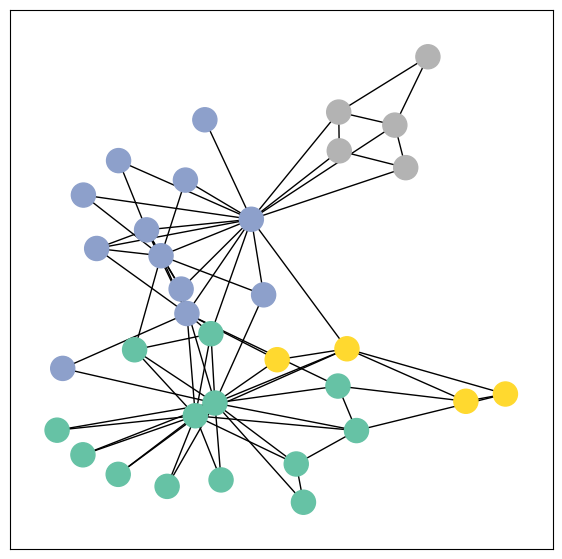

In [5]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

### Graph Neural Networks 网络定义：
- **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) 定义如下：
$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$
- PyG 文档 [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv)

In [6]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 4) # 只需定义好输入特征和输出特征即可
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index) # 输入特征与邻接矩阵（注意格式，上面那种）
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  
        
        # 分类层
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


### 输出特征展示
- 最后不是输出了两维特征嘛，画出来看看长啥样
- 但是，但是，现在咱们的模型还木有开始训练。。。

Embedding shape: [34, 2]


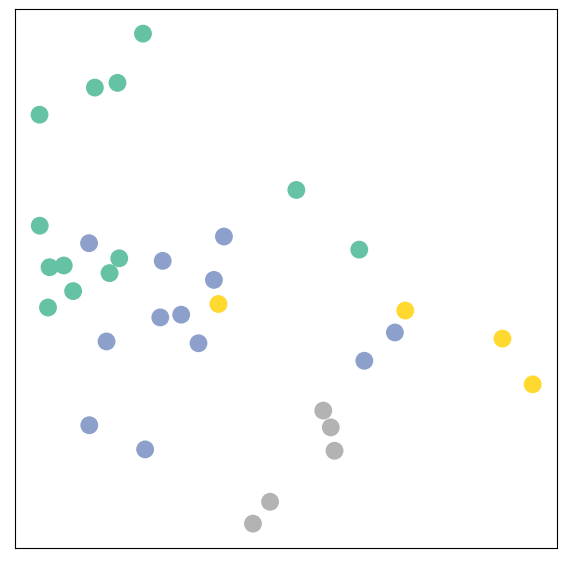

In [7]:
model = GCN()

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize_embedding(h, color=data.y)

### 训练模型(semi-supervised)

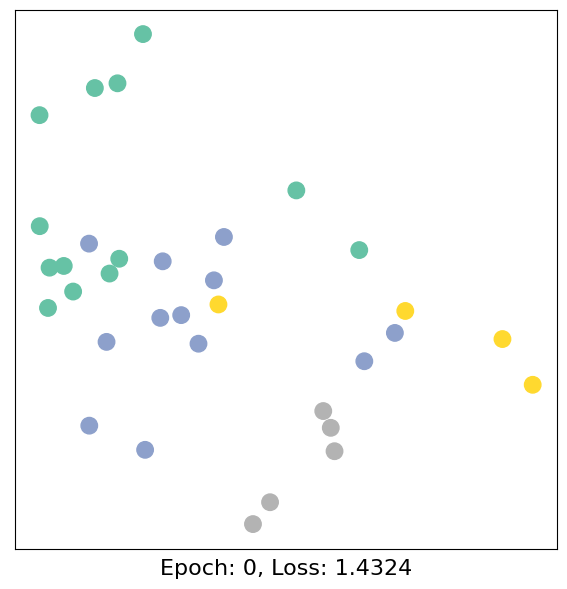

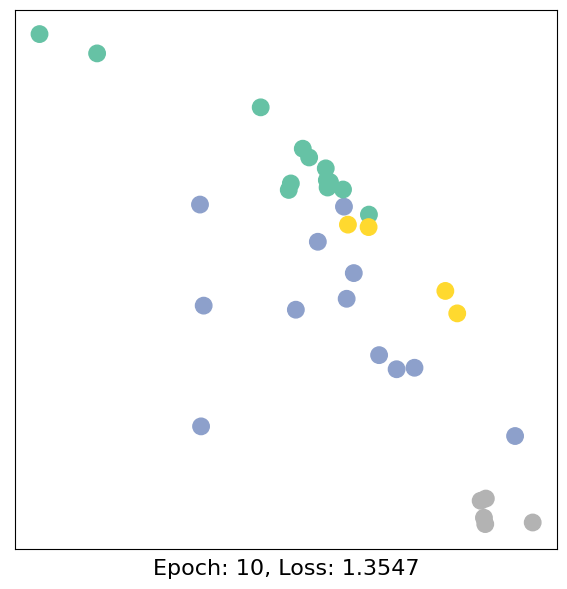

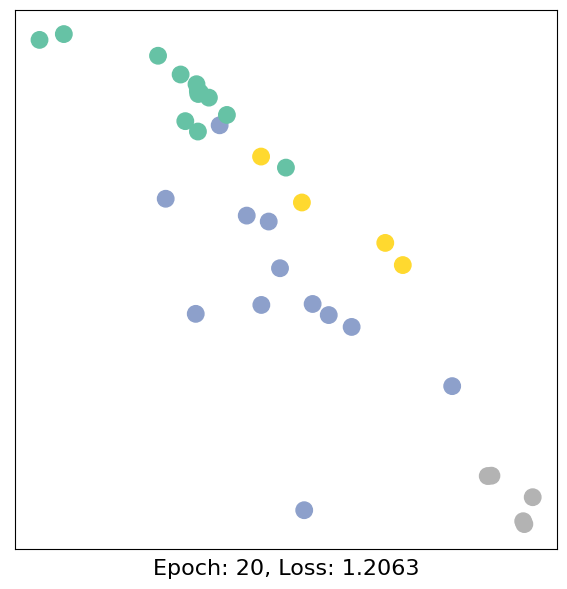

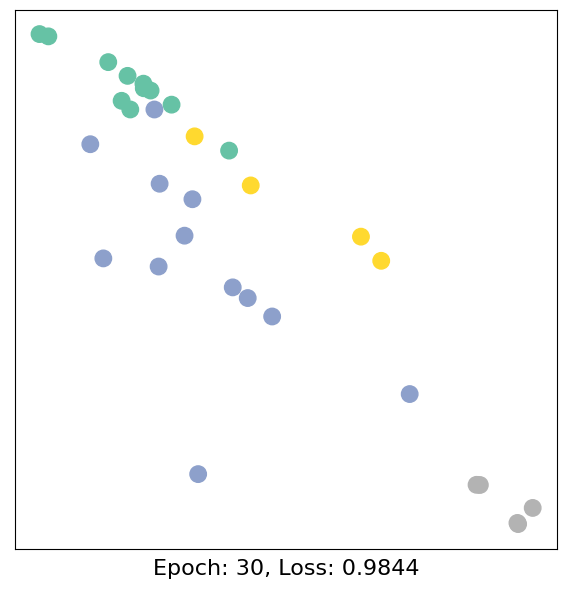

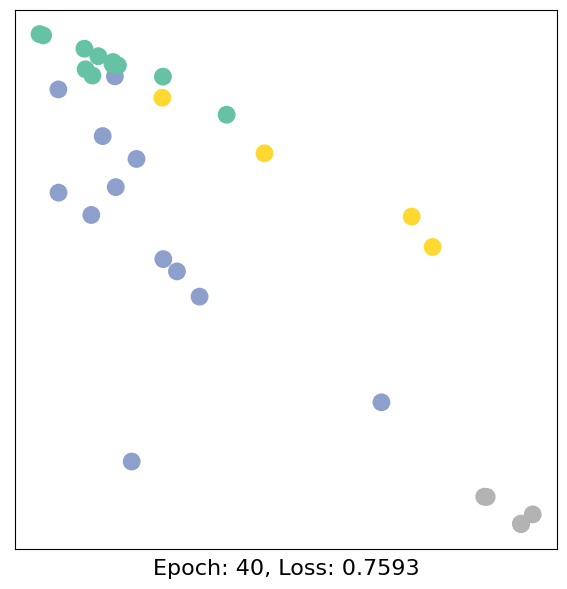

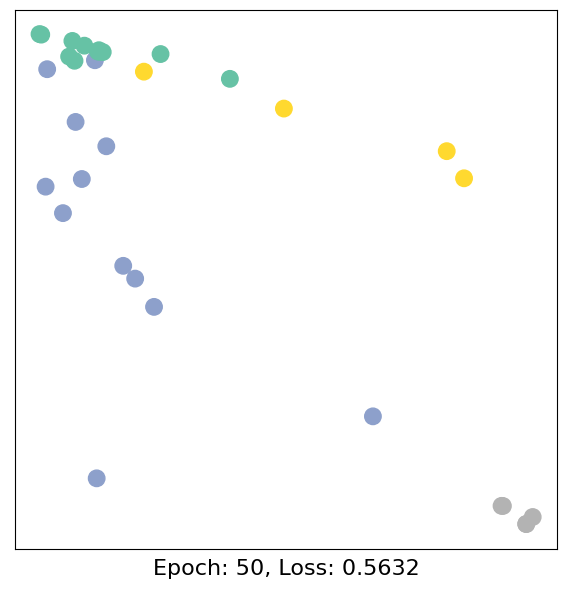

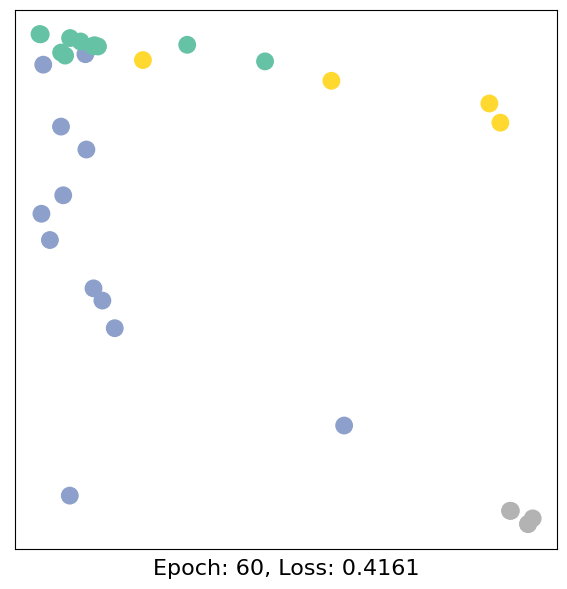

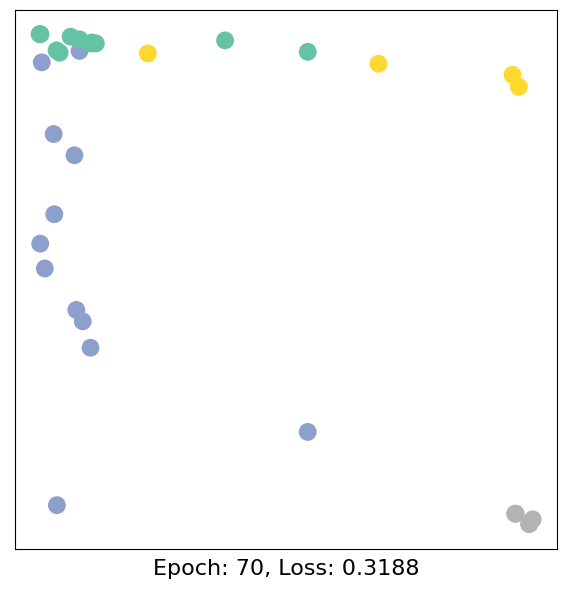

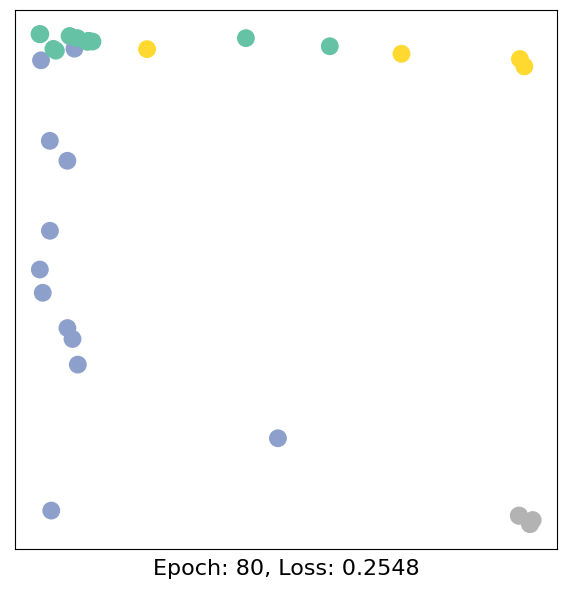

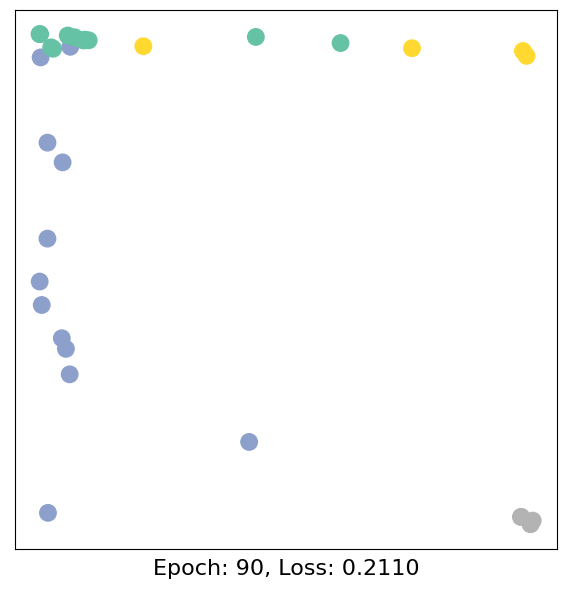

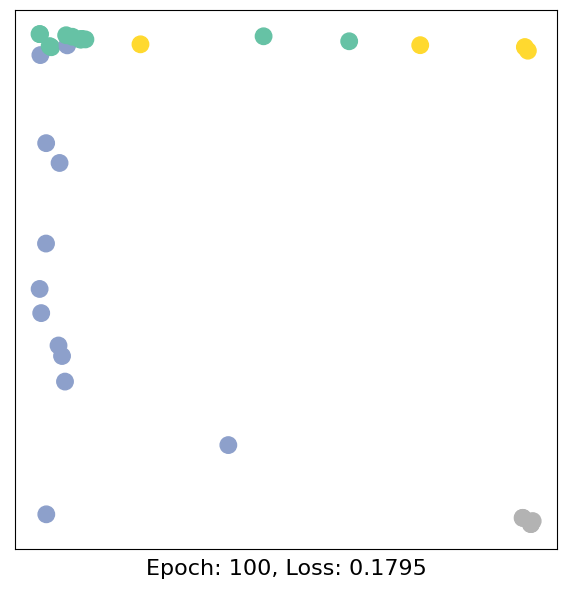

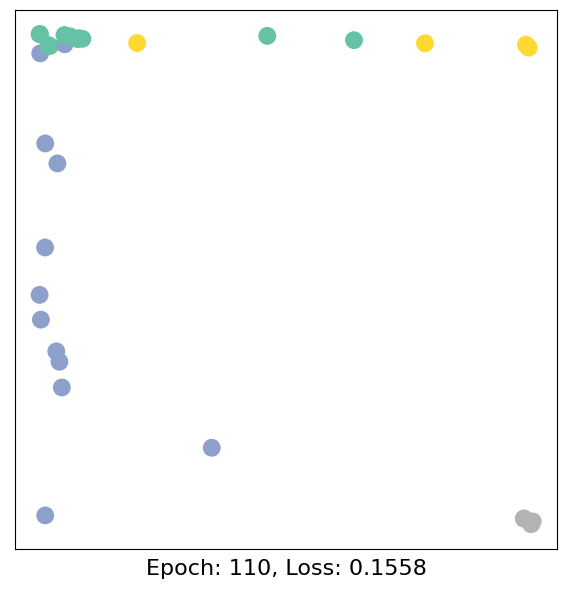

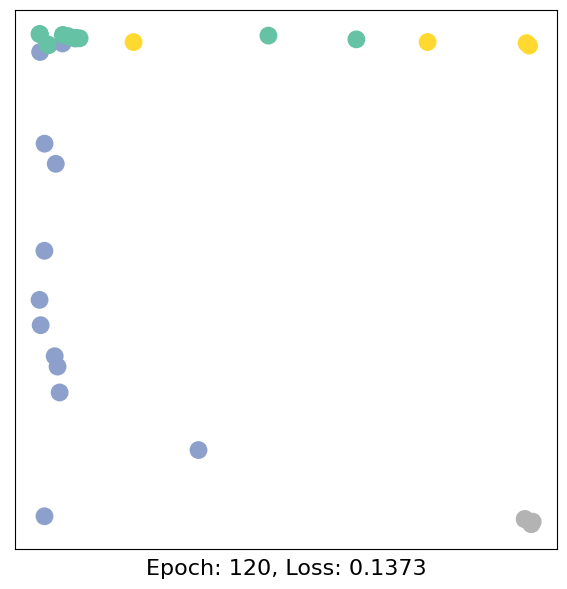

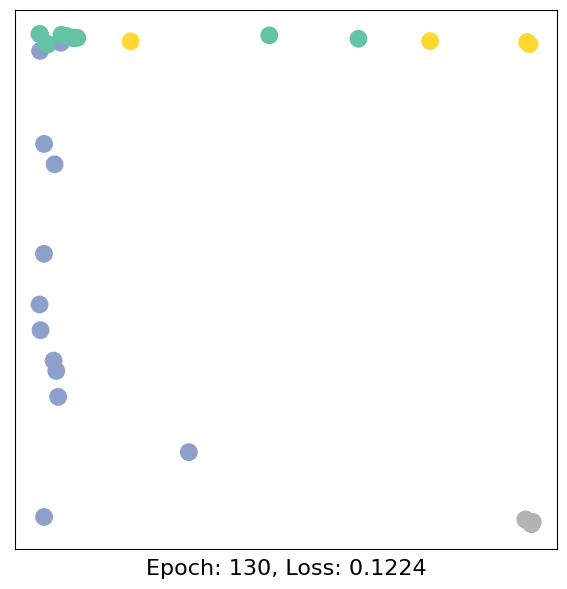

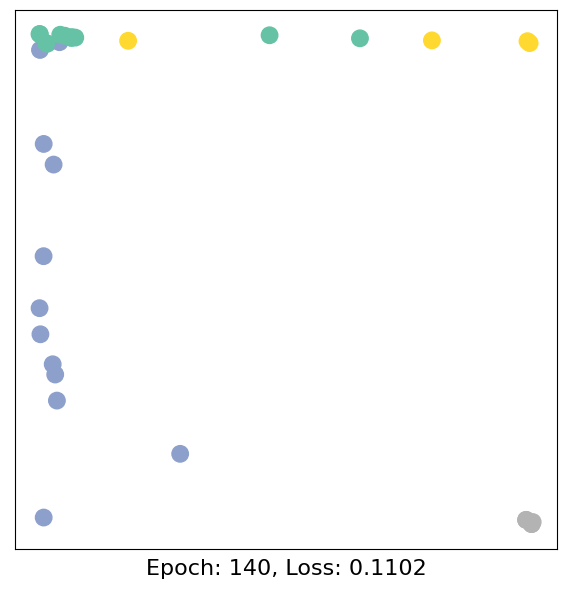

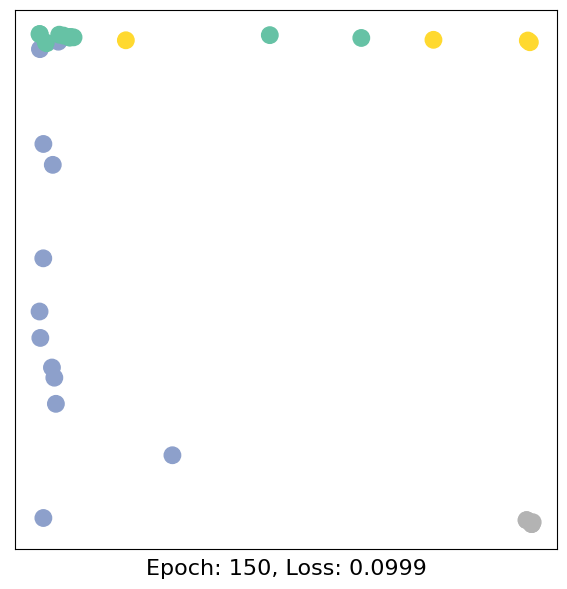

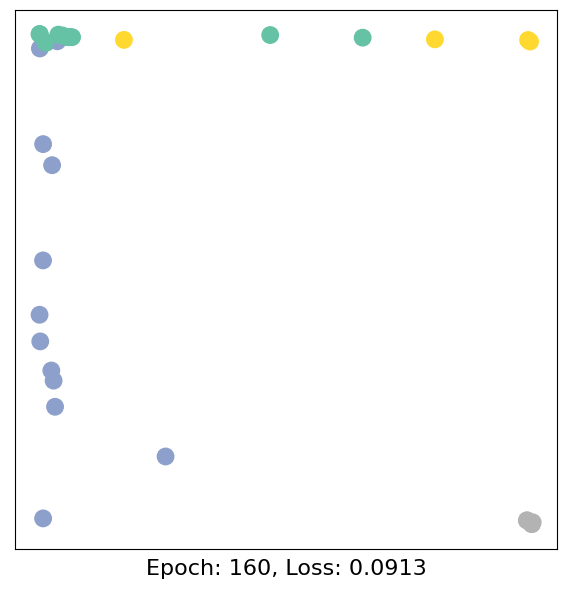

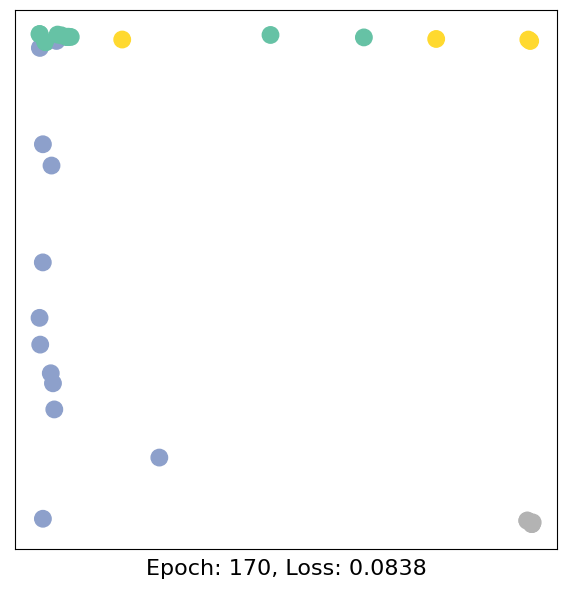

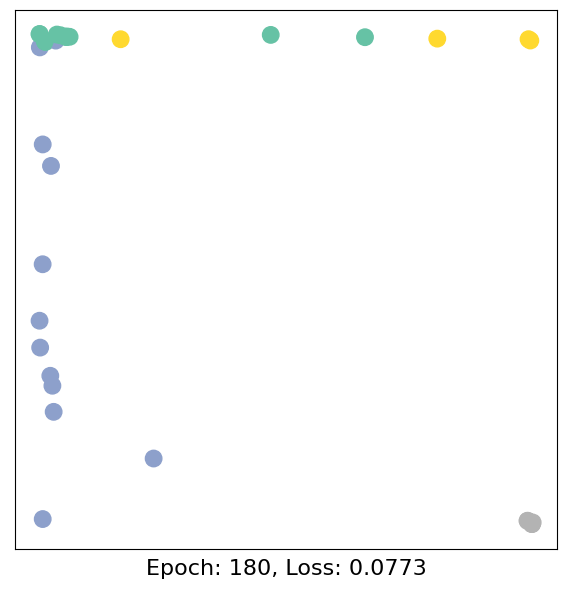

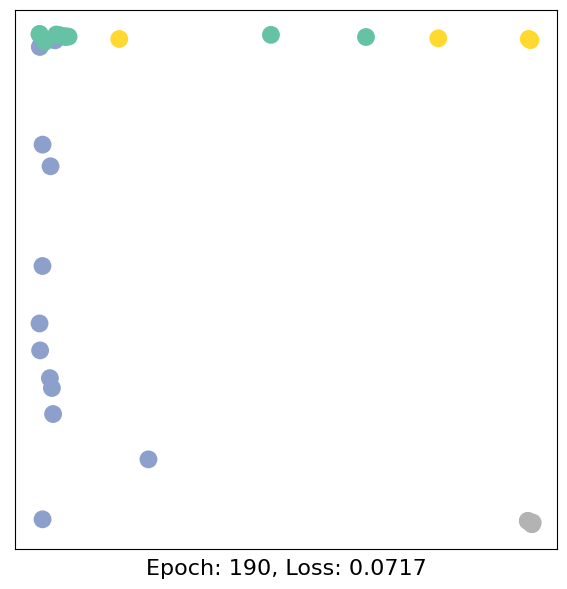

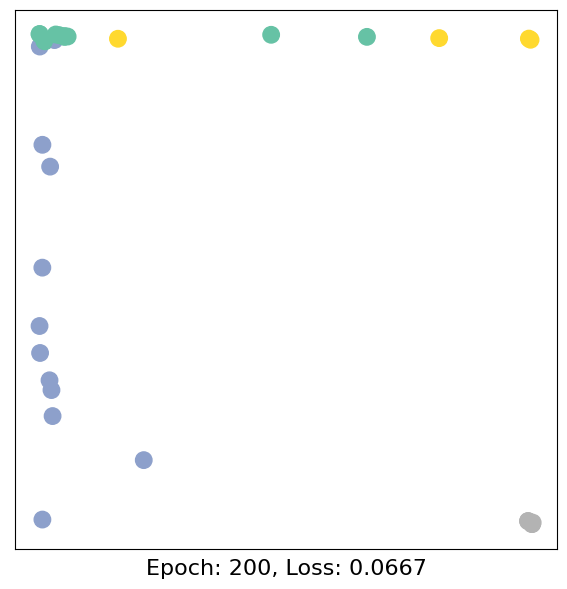

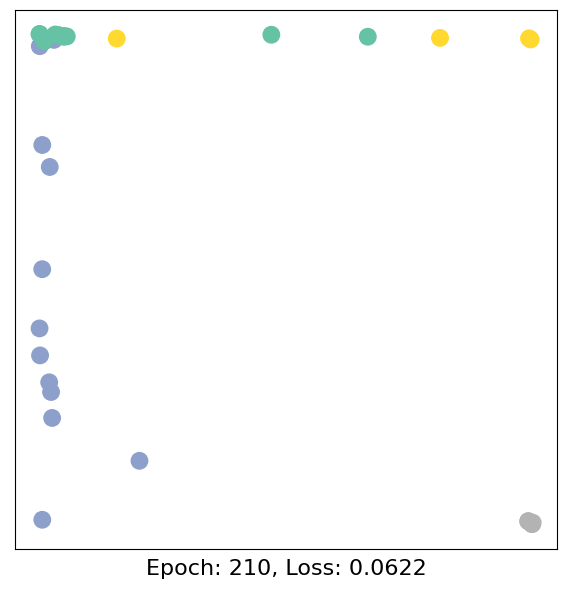

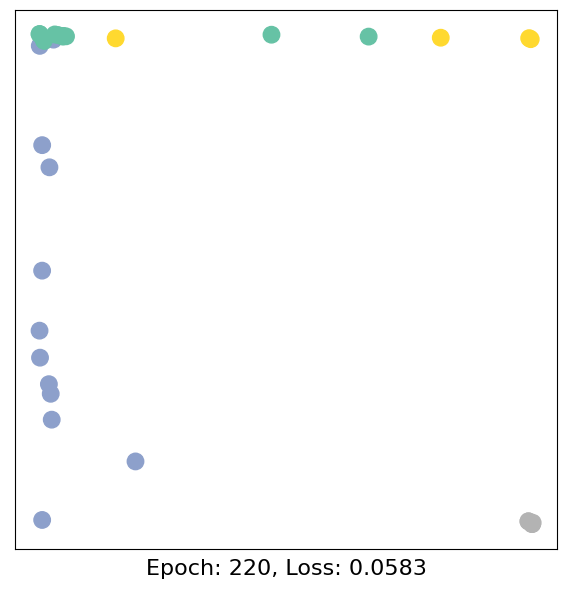

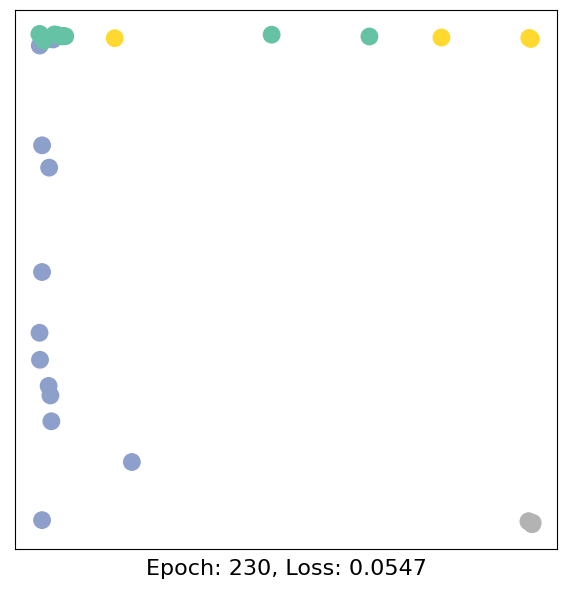

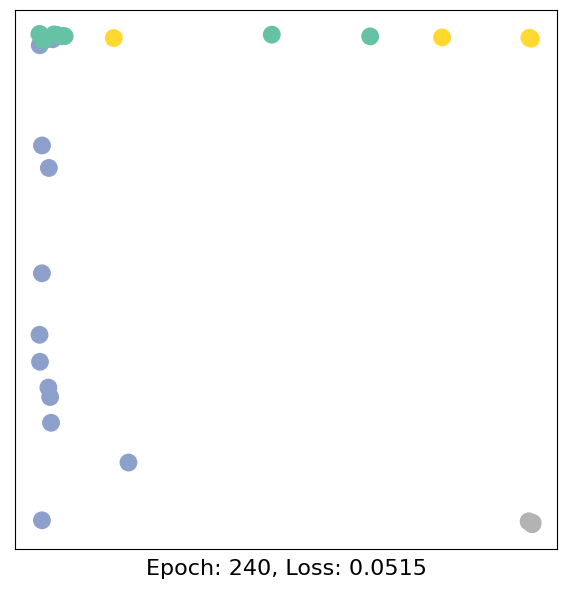

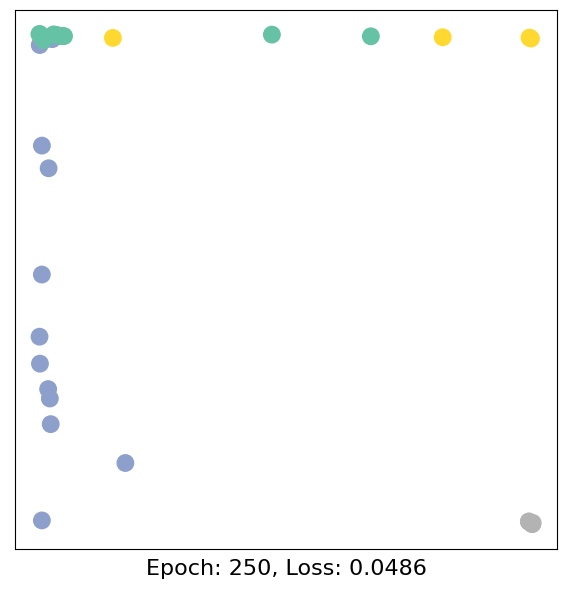

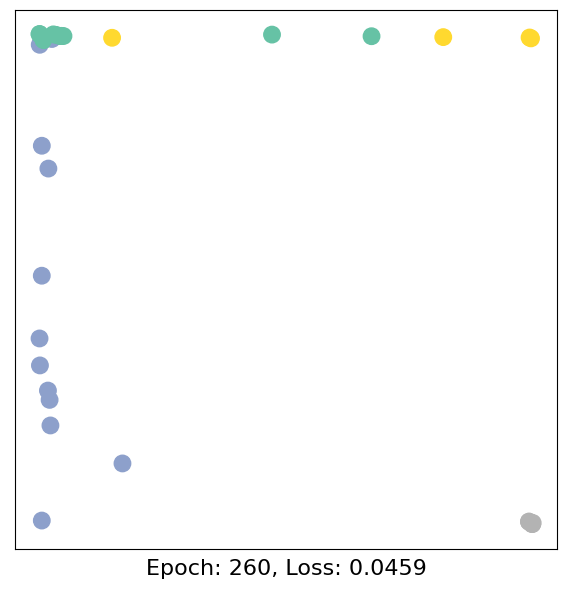

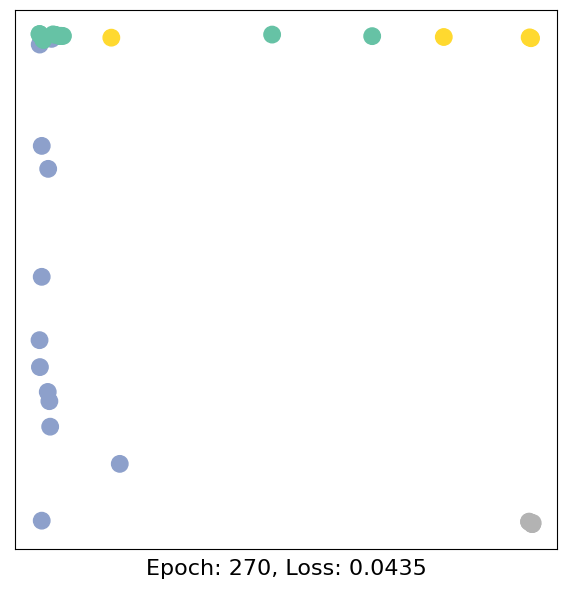

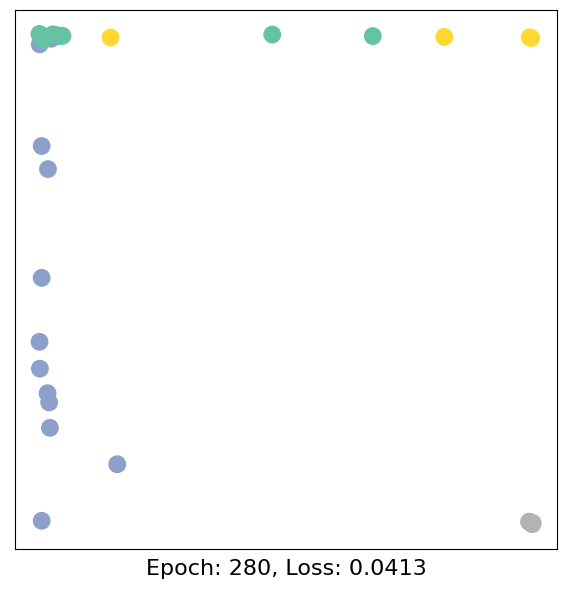

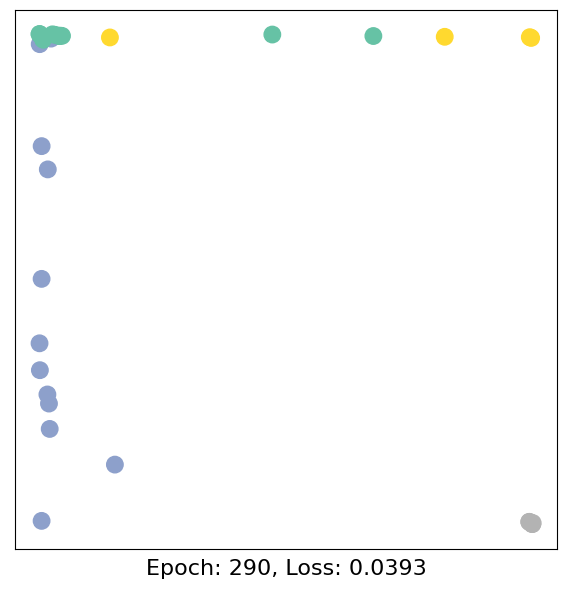

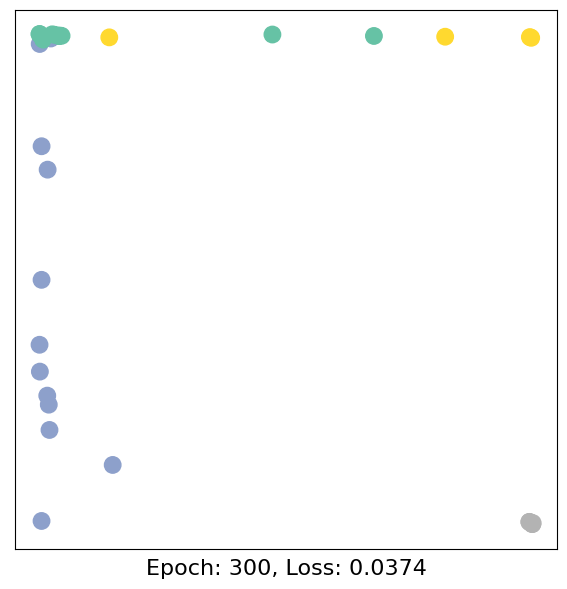

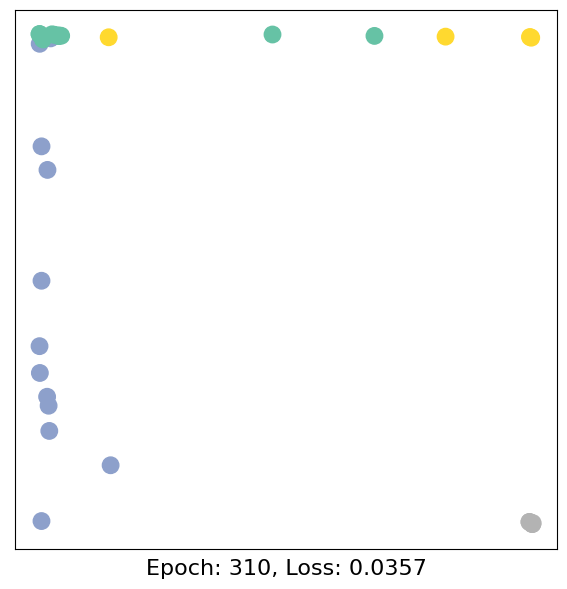

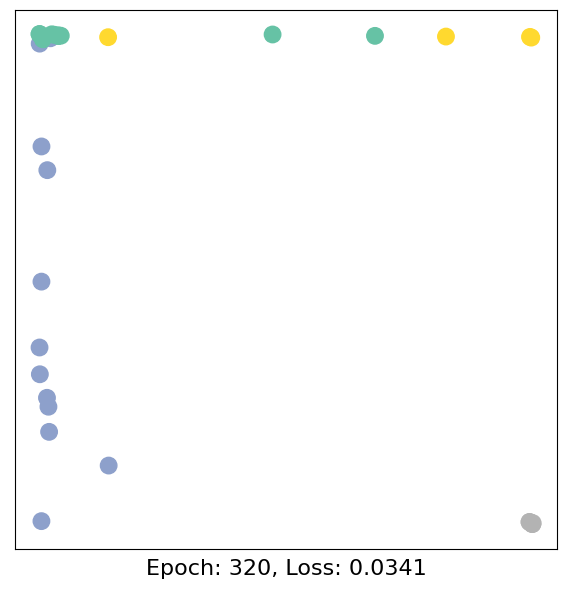

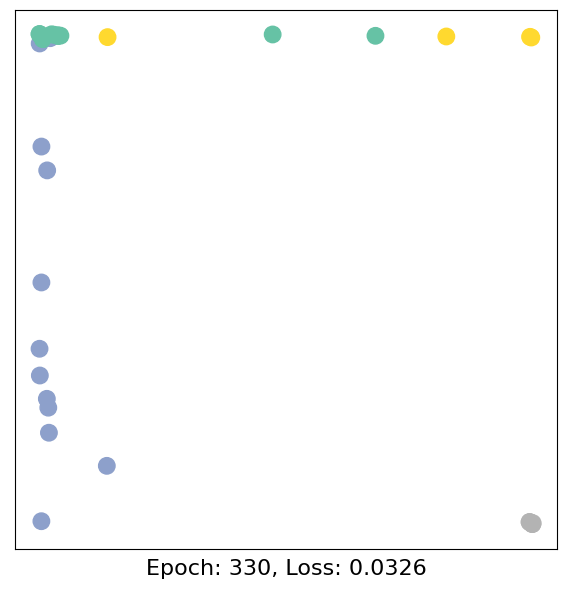

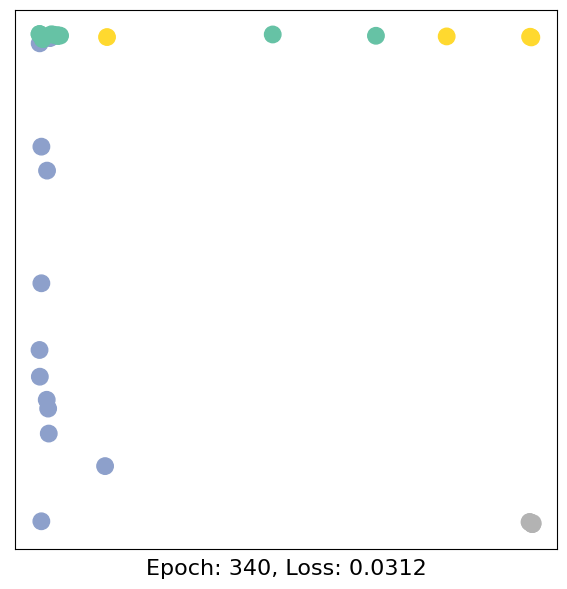

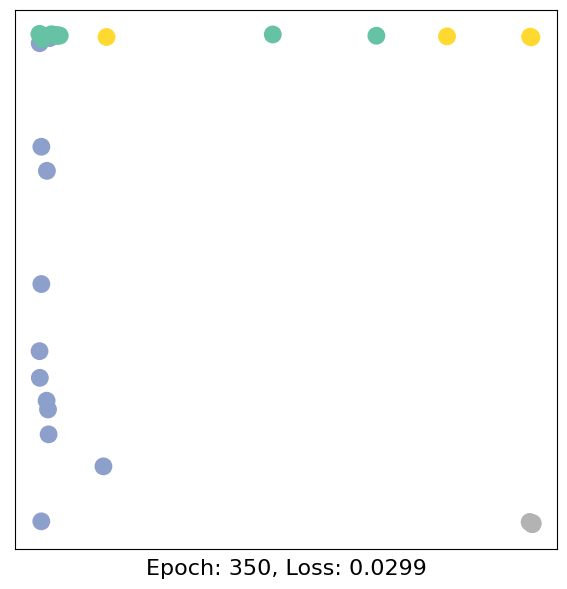

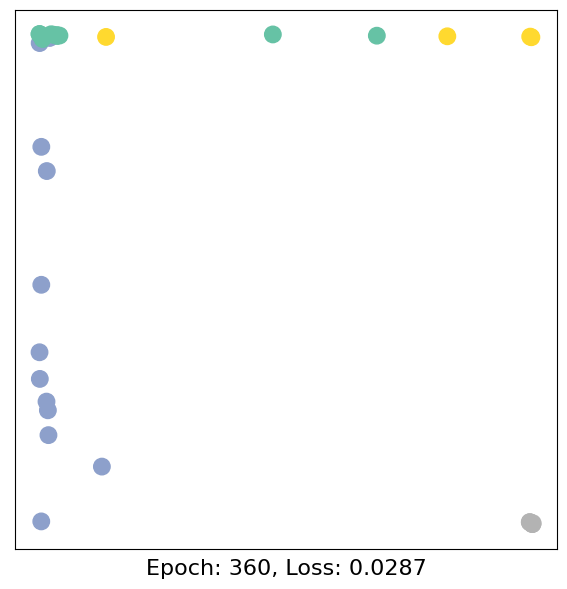

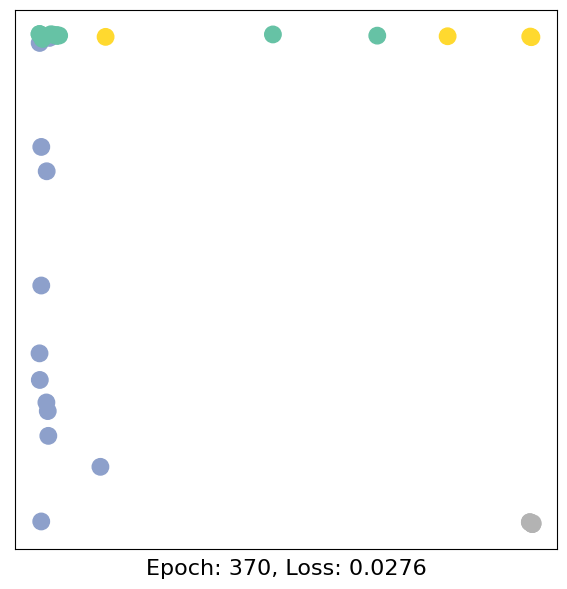

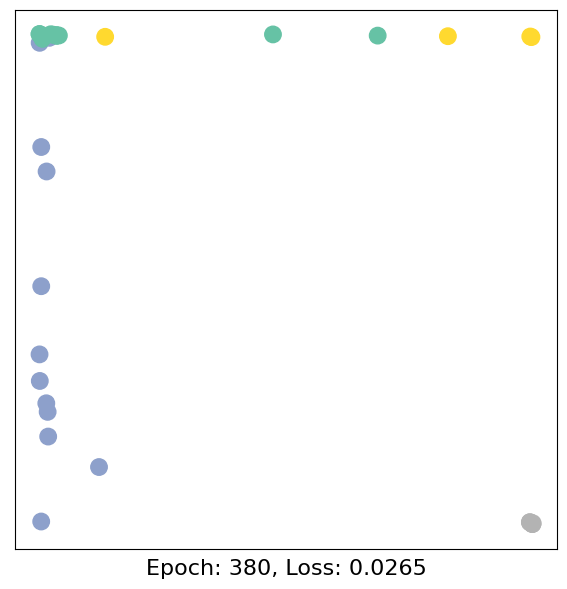

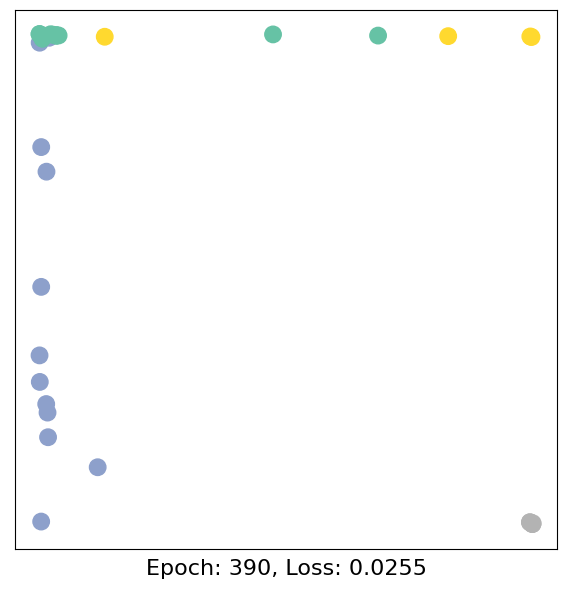

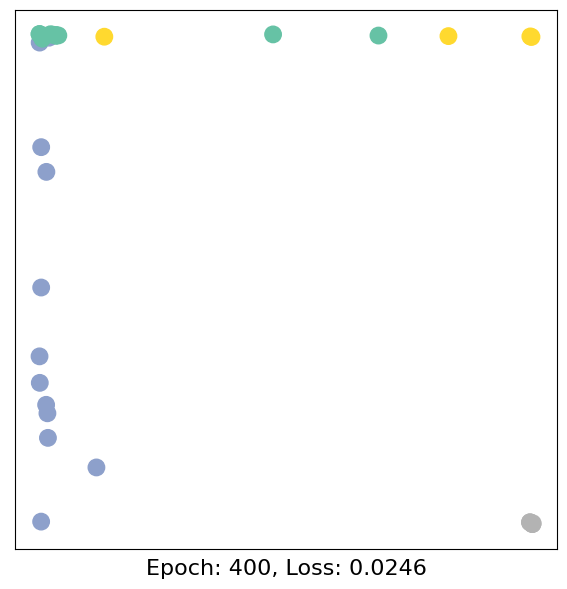

In [8]:
import time

model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  
    out, h = model(data.x, data.edge_index) #h是两维向量，主要是为了咱们画个图 
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # semi-supervised
    loss.backward()  
    optimizer.step()  
    return loss, h

for epoch in range(401):
    loss, h = train(data)
    if epoch % 10 == 0:
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)